# AI index data

We generate regional activity statistics for the AI index

## Preamble

In [1]:
import pandas as pd
import numpy as np
import datetime

%matplotlib inline

today = str(datetime.date.today())

In [2]:
# Functions

def get_cited_papers(data,citation_var,q=0.75):
    '''
    This function subsets a dataset returning the most cited papers of the period (based on the citation variable and the quantile)
    
    '''
    #Get the quantile
    citation_quantile = data[citation_var].quantile(q)
    
    #Subset the data
    subset_data = data.loc[data[citation_var]>=citation_quantile]

    return(subset_data)


def get_high_cited_year(data,q,year_lims):
    '''
    This function extracts high cited papers by year (to control for citation times).
    
    '''
    #This loops over the years and extracts papers in the top quantile of activity.
    
    out = pd.concat([get_cited_papers(data.loc[data['year_created']==x,:],'citation_count',
                                      q) for x in np.arange(year_lims[0],year_lims[1])])
    
    return(out)

def create_lq_df(df,year=None):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    
    if year!=None:
        lqs['period'] = year
    
    return(lqs)

## Load data

In [3]:
arx_papers = pd.read_csv('input_data/23_7_2019_ai_index_papers.csv',compression='zip')

In [4]:
arx_papers.head()

,Unnamed: 0,Unnamed: 0.1,article_id,article_created,article_updated,article_title,journal_ref,doi,summary,citation_count,...,institute_name,institute_city,institute_state,institute_lat,institute_lon,year_created,institute_country,institute_region,country_reg,dl_cat
0,0,0,0704.0002,2007-03-30,2008-12-13,Sparsity-certifying Graph Decompositions,NaN,NaN,"We describe a new algorithm, the $(k,\ell)$-...",18.0,...,Smith College,Northampton,Massachusetts,42.318119,-72.638139,2007,United States of America,Massachusetts,US_Massachusetts,not_dl
1,1,1,0705.1541,2007-05-10,NaN,Unfolding Manhattan Towers,NaN,NaN,We provide an algorithm for unfolding the su...,15.0,...,Smith College,Northampton,Massachusetts,42.318119,-72.638139,2007,United States of America,Massachusetts,US_Massachusetts,not_dl
2,2,2,0707.4258,2007-07-28,2009-06-24,Star Unfolding Convex Polyhedra via Quasigeode...,NaN,NaN,We extend the notion of star unfolding to be...,12.0,...,Smith College,Northampton,Massachusetts,42.318119,-72.638139,2007,United States of America,Massachusetts,US_Massachusetts,not_dl
3,3,3,0709.1942,2007-09-12,NaN,Connecting Polygonizations via Stretches and T...,NaN,NaN,We show that the space of polygonizations of...,4.0,...,Smith College,Northampton,Massachusetts,42.318119,-72.638139,2007,United States of America,Massachusetts,US_Massachusetts,not_dl
4,4,4,0709.3554,2007-09-21,NaN,A New Lower Bound on Guard Placement for Wirel...,NaN,NaN,The problem of wireless localization asks to...,8.0,...,Smith College,Northampton,Massachusetts,42.318119,-72.638139,2007,United States of America,Massachusetts,US_Massachusetts,not_dl


This data has already been labelled with DL / non DL categories. We use it to produce regional counts and RCA indices

### Set some parameters for analysis

These could be changed to implement a country-level analysis, create different citation thresholds and thresholds for discretisation etc

In [5]:
#Geography to focus on
geo = 'institute_region'

#Rank in the year citation
high_cited = 0.5

#Number of locations to focus on (ranked by activity)
top_l = 40

#Years to focus on
focus_years = [2000,2019]

#Threshold for discretising years
year_thres = 2012


### Additional processing

In [6]:
#List of high activity regions (we use it to subset the RCAs and focus on high activity locations)
locs = arx_papers[geo].value_counts()
locs.head()

California       11361
Massachusetts     5424
Beijing           4365
New York          4124
Ontario           3532
Name: institute_region, dtype: int64

In [7]:
top_locs = locs.index[:top_l]

In [8]:
# We focus on high cited (above median) papers to capture influence / quality rather than quantity
arx_high = get_high_cited_year(arx_papers,q=high_cited,year_lims=focus_years)

## Yearly

### Paper counts

In [9]:
high_counts = pd.concat([pd.crosstab(arx_high.loc[arx_high['year_created']==y,geo],
                           arx_high.loc[arx_high['year_created']==y,'dl_cat'])['dl'] for y in np.arange(2008,2019)],axis=1,sort=True).fillna(0)

high_counts.columns = np.arange(2008,2019)

In [10]:
counts_year = high_counts.loc[high_counts.sum(axis=1)>0].sort_values(2018,ascending=False)

counts_year.head(n=10)

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
California,3.0,8.0,24.0,31.0,32.0,36.0,100.0,203.0,335.0,563.0,717.0
Beijing,0.0,1.0,5.0,2.0,10.0,12.0,54.0,90.0,189.0,336.0,515.0
Massachusetts,1.0,4.0,3.0,10.0,27.0,19.0,37.0,92.0,127.0,195.0,322.0
New York,1.0,2.0,2.0,11.0,8.0,28.0,29.0,64.0,98.0,155.0,243.0
Maryland,0.0,0.0,3.0,1.0,10.0,15.0,22.0,47.0,84.0,139.0,202.0
South West Community Development Council,0.0,2.0,2.0,3.0,17.0,16.0,27.0,61.0,86.0,112.0,195.0
Guangdong,0.0,0.0,0.0,0.0,4.0,0.0,4.0,35.0,43.0,74.0,186.0
Illinois,0.0,2.0,2.0,6.0,15.0,12.0,11.0,47.0,67.0,96.0,162.0
Texas,3.0,6.0,2.0,5.0,10.0,8.0,34.0,39.0,45.0,96.0,148.0
Shanghai,0.0,1.0,1.0,0.0,3.0,5.0,13.0,15.0,45.0,97.0,140.0


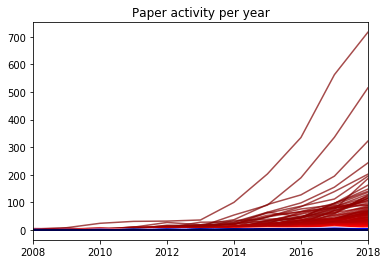

In [11]:
counts_year.T.plot(legend=False,cmap='seismic_r',title='Paper activity per year',alpha=0.7)

In [12]:
counts_year.to_csv(f'output_data/{today}_counts_year.csv')

## RCAs

In [13]:
rca_year = pd.concat([create_lq_df(pd.crosstab(arx_high.loc[arx_high['year_created']==y,geo],
                           arx_high.loc[arx_high['year_created']==y,'dl_cat']))['dl'] for y in np.arange(2008,2019)],axis=1,sort=True).fillna(0)

rca_year.columns = np.arange(2008,2019)

In [14]:
#LQs focusing on the top 100 regions
rca_year.loc[top_locs].sort_values(2018,ascending=False).head(n=10)

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Beijing,0.000000,1.073803,2.167677,0.464449,1.341593,0.962417,1.872748,1.315873,1.590960,1.488500,1.522979
Quebec,0.000000,0.000000,0.000000,2.593176,2.491530,3.247430,2.683011,2.247985,1.731164,1.521855,1.379772
Australian Capital Territory,5.191824,5.624680,2.341091,2.593176,0.000000,1.007462,1.031126,1.517213,1.187902,1.030071,1.328813
South West Community Development Council,0.000000,1.629218,0.907400,0.686429,1.546915,1.334145,1.202981,1.412528,1.330650,1.145302,1.293290
Royal Borough of Kensington and Chelsea,0.000000,0.000000,0.000000,1.196850,2.790514,0.656649,0.763797,0.960184,1.162894,1.154598,1.272270
Maryland,0.000000,0.000000,1.950909,0.471487,1.835864,2.020460,1.833113,1.623735,1.524793,1.415805,1.265970
Shanghai,0.000000,2.624851,1.026794,0.000000,1.255731,1.459221,1.737639,0.905048,1.419580,1.476200,1.250159
Cambridgeshire,0.000000,0.000000,0.000000,1.481815,2.092885,0.700426,1.573710,1.427965,1.066922,1.231978,1.193302
South Australia,2.396226,5.062212,2.601212,1.637795,1.006195,2.529316,2.105216,1.427965,1.317268,1.347157,1.189744
California,0.543330,0.787455,1.463182,1.422804,0.664408,0.642156,1.156017,1.223110,1.183155,1.162464,1.178109


This is likely to be noisy on a yearly basis so perhaps better to smooth it.

Also produce the discretised table with before / after 2012

In [15]:
rca_year.to_csv(f'output_data/{today}_rca_year.csv')

## Pre / post 2012

In [16]:
#Add a variable for discretising
arx_high['discr'] = [f'pre_{year_thres}' if x<=2012 else f'post_{year_thres}' for x in arx_high['year_created']]

discr_vars = [f'pre_{year_thres}',f'post_{year_thres}']

### Counts

In [17]:
counts_discr = pd.concat([pd.crosstab(arx_high.loc[arx_high['discr']==discr,geo],
                           arx_high.loc[arx_high['discr']==discr,'dl_cat'])['dl'] for discr in discr_vars],axis=1,sort=True).fillna(0)

counts_discr.columns = discr_vars

In [18]:
counts_discr.sort_values(discr_vars[1],ascending=False).head(n=10)

,pre_2012,post_2012
California,105.0,1954.0
Beijing,20.0,1196.0
Massachusetts,47.0,792.0
New York,28.0,617.0
Maryland,20.0,509.0
South West Community Development Council,24.0,497.0
Illinois,28.0,395.0
Bavaria,16.0,384.0
Texas,28.0,370.0
Ontario,22.0,362.0


In [19]:
counts_discr.to_csv(f'output_data/{today}_counts_discretised.csv')

### LQ

In [20]:
lq_discr = pd.concat([create_lq_df(pd.crosstab(arx_high.loc[arx_high['discr']==discr,geo],
                           arx_high.loc[arx_high['discr']==discr,'dl_cat']))['dl'] for discr in discr_vars],axis=1,sort=True).fillna(0)

lq_discr.columns = discr_vars

In [21]:
lq_discr.loc[top_locs].sort_values(discr_vars[1],ascending=False).head(n=10)

,pre_2012,post_2012
Quebec,1.923416,1.684241
Beijing,1.313052,1.588248
Maryland,1.649563,1.473750
Shanghai,0.976973,1.426469
South Australia,1.823683,1.368928
South West Community Development Council,1.283113,1.242089
Oxfordshire,0.693513,1.228139
Royal Borough of Kensington and Chelsea,1.414927,1.213193
Cambridgeshire,1.504539,1.185639
Canton of ZÃ¼rich,0.923684,1.154979


In [22]:
lq_discr.to_csv(f'output_data/{today}_lq_discretised.csv')